## Connect Google Drive


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

In [ ]:
%cd /content/drive/MyDrive/Fei Tian Middletown /Fall 2022/ML & AI/Final Project/src

/content/drive/MyDrive/Fei Tian Middletown /Fall 2022/ML & AI/Final Project/src


# Imports


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from general import GeneralUtil as util

# Train Image Classifier CNN


## 1. Load Data


In [ ]:
# Change the root directory to the path of the project
ROOT_DIR = "/kaggle/working/American-Sign-Language-Recogniztion-CNN"
TRAINING_PATH = f"{ROOT_DIR}/images/training"
TESTING_PATH = f"{ROOT_DIR}/images/testing"

### Constants


In [ ]:
# Set the classes
classes = ("A", "B", "C", "D", "E")
# GPU Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### In house functions


In [ ]:
def display_sample_image(imageloader, n=1):
    """Display a sample of the images in the given image loader"""
    plt.rcParams["figure.figsize"] = (10, 10)

    def _imshow(img):
        img = img / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    for _ in range(n):
        # get some random images
        dataiter = iter(imageloader)
        images, labels = next(dataiter)

        # show images
        _imshow(torchvision.utils.make_grid(images))
        # print labels
        print(" ".join("%12s" % classes[labels[j]] for j in range(len(images))))


def plot_acc_loss(train_accs, test_accs, train_losses, test_losses, caption):
    """Plot the accuracy and loss"""
    # Visualize the loss / acc
    plt.figure()
    plt.plot(train_accs, label="Train")
    plt.plot(test_accs, label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Classification Accuracy vs Epoch: {}".format(caption))

    # Visualize the loss / acc
    plt.figure()
    plt.plot(train_losses, label="Train")
    plt.plot(test_losses, label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("Cross Entropy Loss")
    plt.legend()
    plt.title("Cross Entropy Loss vs Epoch: {}".format(caption))

    return


def plot_confusion_matrix(y_true, y_pred):
    """Plot the confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [ ]:
def load_data(train_path, test_path, batch_size=5):
    # --------------------------------------------------------------------------------------------------
    # Set up transformer to normalize and transform the data
    # --------------------------------------------------------------------------------------------------
    train_transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    train_transform = transforms.Compose(
        [
            #             transforms.RandomHorizontalFlip(),
            # https://pytorch.org/vision/main/auto_examples/plot_transforms.html#randomresizedcrop
            transforms.RandomResizedCrop((40, 40), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
            # https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    test_transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # --------------------------------------------------------------------------------------------------
    # Create the training and test datasets as well as the data loaders
    # --------------------------------------------------------------------------------------------------
    # Data Sets
    train_dataset = datasets.ImageFolder(TRAINING_PATH, transform=train_transform)
    test_dataset = datasets.ImageFolder(TESTING_PATH, transform=test_transform)
    val_dataset = datasets.ImageFolder(TRAINING_PATH, transform=train_transform)

    torch.manual_seed(42)
    train_set, _ = torch.utils.data.random_split(train_dataset, [310, 50])
    torch.manual_seed(42)  # Think why do we do this?
    _, val_set = torch.utils.data.random_split(val_dataset, [310, 50])

    # Data Loaders
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        drop_last=True,
        pin_memory=True,
        shuffle=True,
        num_workers=2,
    )

    val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=2,
    )
    util.print(f"Successfully loaded images\nBatch size: {batch_size}", color="green")

    return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = load_data(TRAINING_PATH, TESTING_PATH)


Successfully loaded images
Batch size: 5


Let's visualize some of the images in the dataset.


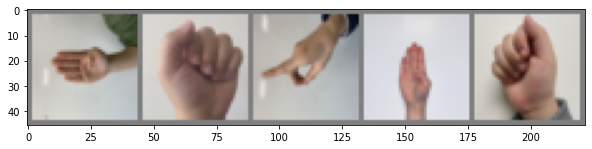

           B            A            D            B            A


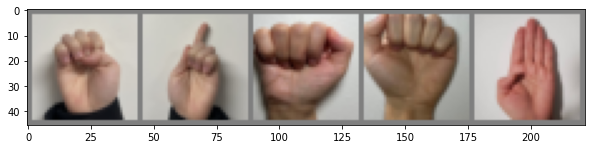

           E            D            A            A            B


In [ ]:
display_sample_image(train_loader, n=2)


## 2. Build CNN Architecture


This CNN architecture consists of 3 convolutional layers, 1 max pooling layer, and 1 output layer. The convolutional layers are used to extract features from the images. The max pooling layers are used to reduce the dimensionality of the feature maps. The fully connected layers are used to classify the images. The output layer is used to output the class probabilities.


In [ ]:
class ASL_CNN(nn.Module):
    def __init__(self, num_classes: int = 5, dropout: float = 0.5) -> None:
        super().__init__()

        self.features = nn.Sequential(
            # Conv1 https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # Conv2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  #  15x15
            # Conv3
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  #  7x7
        )
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3))
        # average pooling, just specify output size
        # https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),  # p = dropout probability
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )

        # initialize the weights
        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Based on our previous discussion, we should initialize the convolutions according to the activation function
                # Fan-out focuses on the gradient distribution,
                # and is commonly used
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

### 2.1 Architecture Consistency Check


In [ ]:
# Architechture consistency check
net = ASL_CNN(num_classes=5, dropout=0.3)
img = torch.randn(4, 3, 32, 32, dtype=torch.float)
x1 = net.features(img)
x2 = net(img)
print(x1.shape, x2.shape)
net

torch.Size([4, 256, 7, 7]) torch.Size([4, 5])


ASL_CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(3, 3))
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=2304, out_features=1024, bias=True)
    (2): ReLU(inplace=True)
  

## 3. Define Loss Function and Optimizer


Let's use cross entropy loss and Adam optimizer for the first model. Later we will try other loss functions and optimizers such as SGD which is more commonly used for image classification.


In [ ]:
net = ASL_CNN(num_classes=5, dropout=0.5)
net.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()
# Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
# optimizer = optim.SGD(net.parameters(), lr=6.14E-02, momentum=0.9)


## 4. Train the CNN


In [ ]:
def train(device=torch.device("cpu"), scheduler=None):
    """Function to train the model"""
    net.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        # Calcualte accuracy
        _, predicted = torch.max(outputs.data.detach().cpu(), 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()

    training_loss.append(running_loss / i)
    training_acc.append(100.0 * correct / total)

    return running_loss


def validation(val_loader, device=torch.device("cpu"), verbose=False):
    actual = []
    pred = []

    correct = 0
    total = 0
    running_loss = 0.0
    net.eval()

    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images.to(device))

            loss = criterion(outputs, labels.to(device))
            running_loss += loss.item()

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data.detach().cpu(), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # collect the correct predictions for each class
            for label, prediction in zip(labels, predicted):
                if verbose:
                    actual.append(label.item())
                    pred.append(prediction.item())
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    if verbose:
        print("==" * 30)
        print(f"Accuracy of the network on the test images: {100 * correct / total}%")
        print("==" * 30)
        # print accuracy for each class
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
        print("==" * 30)
        plot_confusion_matrix(actual, pred)

    if not verbose:
        val_acc.append(100.0 * correct / total)
        val_loss.append(running_loss / len(val_loader))

    return running_loss / len(val_loader)


def save_model(net, PATH=f"{ROOT_DIR}/models/", name="asl_cnn.pth"):
    """Function to save the model"""
    torch.save(net.state_dict(), PATH + name)


#### Initial Training


In [ ]:
training_loss = []
training_acc = []
val_acc = []
val_loss = []
EPOCHS = 100

util.print("Training...", header=True, color="cyan")
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    train(device=device)
    validation(val_loader, device=device)
    print(
        f"Epoch #{epoch+1}\tTrain Loss: {training_loss[-1]:.3f}\tValidation Loss: {val_loss[-1]:.3f}"
    )
util.print("Finished Training", color="green")

save_model(net)

Training...
Epoch #1	Train Loss: 1.660	Validation Loss: 1.571
Epoch #2	Train Loss: 1.554	Validation Loss: 1.351
Epoch #3	Train Loss: 1.349	Validation Loss: 1.140
Epoch #4	Train Loss: 1.187	Validation Loss: 0.960
Epoch #5	Train Loss: 1.002	Validation Loss: 1.183
Epoch #6	Train Loss: 0.945	Validation Loss: 0.780
Epoch #7	Train Loss: 0.780	Validation Loss: 0.795
Epoch #8	Train Loss: 0.759	Validation Loss: 0.616
Epoch #9	Train Loss: 0.732	Validation Loss: 0.699
Epoch #10	Train Loss: 0.693	Validation Loss: 0.552
Epoch #11	Train Loss: 0.762	Validation Loss: 0.706
Epoch #12	Train Loss: 0.646	Validation Loss: 0.606
Epoch #13	Train Loss: 0.720	Validation Loss: 0.600
Epoch #14	Train Loss: 0.642	Validation Loss: 0.788
Epoch #15	Train Loss: 0.735	Validation Loss: 0.619
Epoch #16	Train Loss: 0.657	Validation Loss: 0.622
Epoch #17	Train Loss: 0.596	Validation Loss: 0.603
Epoch #18	Train Loss: 0.711	Validation Loss: 0.639
Epoch #19	Train Loss: 0.633	Validation Loss: 0.641
Epoch #20	Train Loss: 0.626	

In [ ]:
validation(val_loader, device=device, verbose=True)


Accuracy of the network on the test images: 82.0%
Accuracy for class A     is: 81.8 %
Accuracy for class B     is: 88.9 %
Accuracy for class C     is: 100.0 %
Accuracy for class D     is: 77.8 %
Accuracy for class E     is: 69.2 %


0.36529247276484966

In the first training, we will use the default hyperparameters. We will use the default learning rate of 0.001, batch size of 5, and 100 epochs. The accuracy is 82%, definitely not the best, but it is a good start.


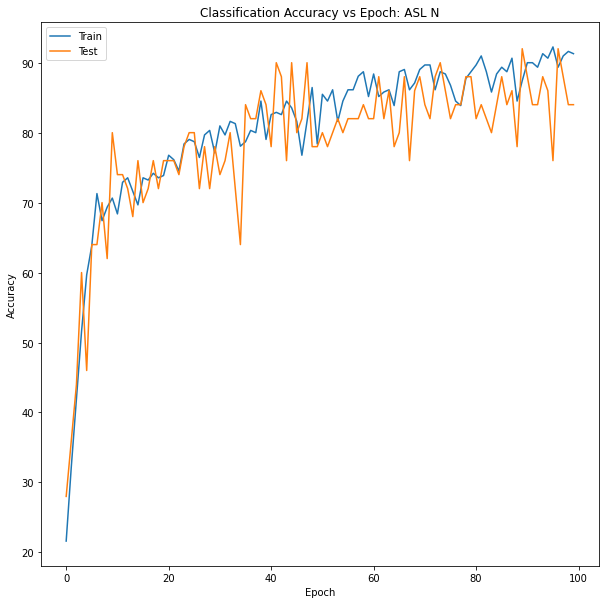

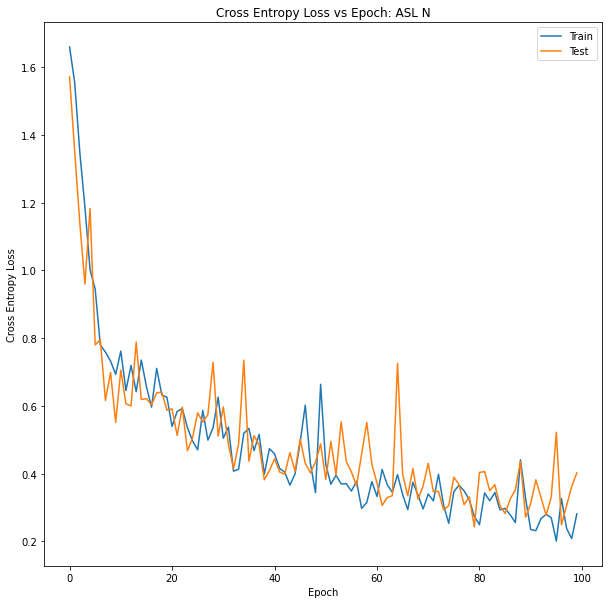

In [ ]:
plot_acc_loss(training_acc, val_acc, training_loss, val_loss, caption="ASL N")

# Hyperparameter Tuning


In this project, we will be focusing on tuning three specific hyperparameters of our CNN: the learning rate, the batch size, and the dropout. The learning rate determines how much the model weights are updated during each training step, the batch size determines the number of training examples used in each iteration of training, and the number dropout determines the probability of any given nueron from being droppped in training.

For the hyperparameter tuning, I will be using a library called Ray


## 5.1 Set up Hyperparameter training


In [ ]:
from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler


def train_asl(config, checkpoint_dir=None, data_dir=None):
    net = ASL_CNN(dropout=config["dropout"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint")
        )
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    train_dataset = datasets.ImageFolder(TRAINING_PATH, transform=train_transform)
    test_dataset = datasets.ImageFolder(TESTING_PATH, transform=test_transform)

    test_abs = int(len(train_dataset) * 0.8)
    train_subset, val_subset = random_split(
        train_dataset, [test_abs, len(train_dataset) - test_abs]
    )

    train_loader = torch.utils.data.DataLoader(
        train_subset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        val_subset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=2
    )

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(
                    "[%d, %5d] loss: %.3f"
                    % (epoch + 1, i + 1, running_loss / epoch_steps)
                )
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(val_loader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [ ]:
def load_data(data_dir="./data"):
    train_transform = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            # https://pytorch.org/vision/main/auto_examples/plot_transforms.html#randomresizedcrop
            transforms.RandomResizedCrop((42, 42), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
            # https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    test_transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    train_dataset = datasets.ImageFolder(TRAINING_PATH, transform=train_transform)
    test_dataset = datasets.ImageFolder(TESTING_PATH, transform=test_transform)

    return train_dataset, test_dataset

In [ ]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    data_dir = os.path.abspath("./data")
    data_dir = "/kaggle/working/American-Sign-Language-Recogniztion-CNN/images"
    load_data(data_dir)

    config = {
        "dropout": tune.choice([0.5, 0.6, 0.7]),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16]),
    }

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2,
    )
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"]
    )
    result = tune.run(
        partial(train_asl, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter,
    )

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
    print(
        "Best trial final validation accuracy: {}".format(
            best_trial.last_result["accuracy"]
        )
    )

    best_trained_model = ASL_CNN(best_trial.config["dropout"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(
        os.path.join(best_checkpoint_dir, "checkpoint")
    )
    best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))


main(num_samples=10, max_num_epochs=10, gpus_per_trial=0)

#### I won't be showing the full output here, but the following was the best fit.

```
== Status ==
Current time: 2022-12-13 04:21:15 (running for 00:15:32.56)
Memory usage on this node: 5.0/15.6 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 8.000: -0.8630328327417374 | Iter 4.000: -1.5763958825005426 | Iter 2.000: -1.4757871826489768 | Iter 1.000: -1.6113163431485495
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/5.36 GiB heap, 0.0/2.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_asl_2022-12-13_04-05-43
Number of trials: 10/10 (10 TERMINATED)
+-----------------------+------------+-----------------+--------------+-----------+-------------+----------+------------+----------------------+
| Trial name            | status     | loc             |   batch_size |   dropout |          lr |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+--------------+-----------+-------------+----------+------------+----------------------|
| train_asl_69e5f_00000 | TERMINATED | 172.19.2.2:9405 |            8 |       0.5 | 0.00810789  | 0.706638 |   0.666667 |                   10 |
| train_asl_69e5f_00001 | TERMINATED | 172.19.2.2:9405 |           16 |       0.5 | 0.000640193 | 1.61274  |   0.194444 |                    1 |
| train_asl_69e5f_00002 | TERMINATED | 172.19.2.2:9405 |            8 |       0.6 | 0.00929849  | 0.706528 |   0.75     |                   10 |
| train_asl_69e5f_00003 | TERMINATED | 172.19.2.2:9405 |            4 |       0.5 | 0.00208321  | 1.61694  |   0.180556 |                    1 |
| train_asl_69e5f_00004 | TERMINATED | 172.19.2.2:9405 |            8 |       0.6 | 0.0423177   | 1.5764   |   0.347222 |                    4 |
| train_asl_69e5f_00005 | TERMINATED | 172.19.2.2:9405 |            4 |       0.7 | 0.00153272  | 1.61149  |   0.152778 |                    1 |
| train_asl_69e5f_00006 | TERMINATED | 172.19.2.2:9405 |            2 |       0.5 | 0.00612583  | 1.64215  |   0.222222 |                    2 |
| train_asl_69e5f_00007 | TERMINATED | 172.19.2.2:9405 |           16 |       0.7 | 0.00375232  | 1.61266  |   0.166667 |                    1 |
| train_asl_69e5f_00008 | TERMINATED | 172.19.2.2:9405 |           16 |       0.7 | 0.00430741  | 1.61114  |   0.222222 |                    1 |
| train_asl_69e5f_00009 | TERMINATED | 172.19.2.2:9405 |            8 |       0.5 | 0.00375614  | 1.61439  |   0.194444 |                    1 |
+-----------------------+------------+-----------------+--------------+-----------+-------------+----------+------------+----------------------+


Best trial config: {'dropout': 0.6, 'lr': 0.00929848823243245, 'batch_size': 8}
Best trial final validation loss: 0.7065282132890489
Best trial final validation accuracy: 0.75
```


That is, acccording to this, the best dropout is 0.6, learning rate should be around 0.009, and batch size should be 8. We can retrain the network with these parameters and see how it performs


## 5.2 Re-Train Network


### Import data


In [ ]:
train_loader, val_loader, test_loader = load_data(
    TRAINING_PATH, TESTING_PATH, batch_size=8
)

Successfully loaded images
Batch size: 8


### Init new network with new Hyperparameters


In [ ]:
net = ASL_CNN(num_classes=5, dropout=0.6)
net.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()
# SGD optimizer
optimizer = optim.SGD(net.parameters(), lr=0.00929848823243245, momentum=0.9)


In [ ]:
training_loss = []
training_acc = []
val_acc = []
val_loss = []
EPOCHS = 200

util.print("Training...", header=True, color="cyan")
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    train(device=device)
    validation(val_loader, device=device)
    print(
        f"Epoch #{epoch+1}\tTrain Loss: {training_loss[-1]:.3f}\tValidation Loss: {val_loss[-1]:.3f}"
    )
util.print("Finished Training", color="green")

save_model(net, name="ray_tuned_asl_cnn.pth")

Training...
Epoch #1	Train Loss: 1.655	Validation Loss: 1.612
Epoch #2	Train Loss: 1.633	Validation Loss: 1.528
Epoch #3	Train Loss: 1.596	Validation Loss: 1.321
Epoch #4	Train Loss: 1.476	Validation Loss: 1.286
Epoch #5	Train Loss: 1.388	Validation Loss: 1.338
Epoch #6	Train Loss: 1.400	Validation Loss: 1.221
Epoch #7	Train Loss: 1.302	Validation Loss: 1.055
Epoch #8	Train Loss: 1.258	Validation Loss: 1.002
Epoch #9	Train Loss: 1.300	Validation Loss: 1.287
Epoch #10	Train Loss: 1.186	Validation Loss: 1.269
Epoch #11	Train Loss: 1.373	Validation Loss: 1.112
Epoch #12	Train Loss: 1.155	Validation Loss: 1.075
Epoch #13	Train Loss: 1.206	Validation Loss: 0.877
Epoch #14	Train Loss: 1.029	Validation Loss: 0.917
Epoch #15	Train Loss: 1.211	Validation Loss: 1.087
Epoch #16	Train Loss: 1.149	Validation Loss: 1.060
Epoch #17	Train Loss: 1.118	Validation Loss: 0.895
Epoch #18	Train Loss: 1.115	Validation Loss: 0.870
Epoch #19	Train Loss: 0.932	Validation Loss: 0.859
Epoch #20	Train Loss: 0.882	

Accuracy of the network on the test images: 87.03703703703704%
Accuracy for class A     is: 81.8 %
Accuracy for class B     is: 90.0 %
Accuracy for class C     is: 100.0 %
Accuracy for class D     is: 90.9 %
Accuracy for class E     is: 78.6 %


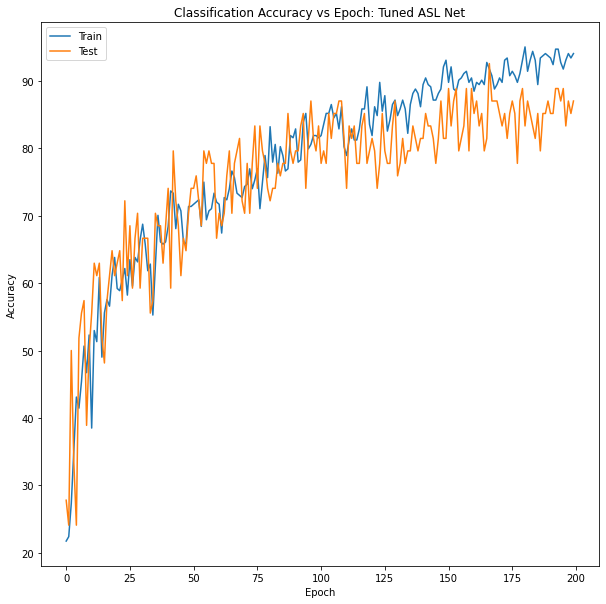

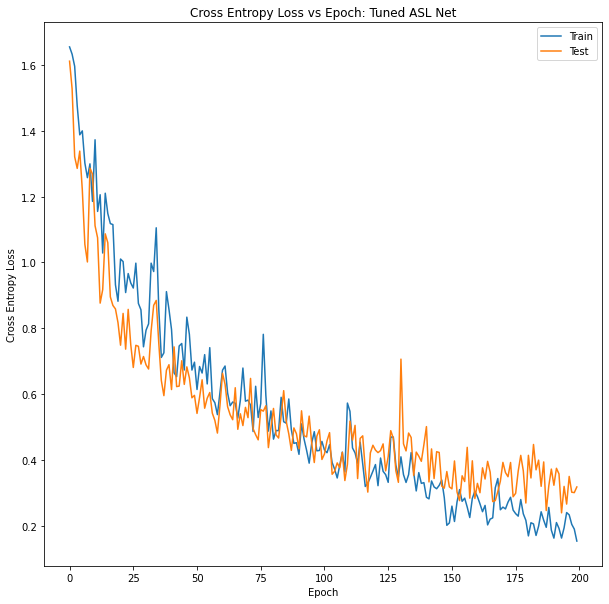

In [ ]:
validation(val_loader, device=device, verbose=True)
plot_acc_loss(training_acc, val_acc, training_loss, val_loss, caption="Tuned ASL Net")

### As we can see, the accuracy is 87%, which is a slight improvement from the initial training. Let's try to improve it further, as I am not convinced that the hyperparameters are the best fit. A good place to start is to try to find the optimal learning rate, as well as working with a different batch size.


### Optimal learning rate

Let's try to use torch lr finder to find the optimum learning rate


In [ ]:
%%capture
!pip install -q torch-lr-finder

In [ ]:
from torch_lr_finder import LRFinder

net = ASL_CNN(num_classes=5, dropout=0.2)
net.to(device)
data_loader = val_loader

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

lr_finder = LRFinder(net, optimizer, criterion, device=device)
lr_finder.range_test(data_loader, end_lr=1, num_iter=100, step_mode="exp")

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.32E-01


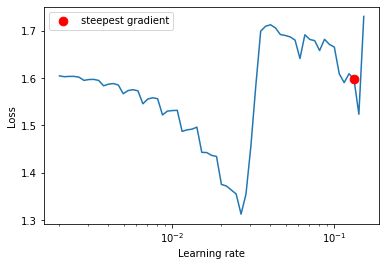

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.1321941148466029)

In [ ]:
lr_finder.plot()


In [ ]:
# !curl -o onecyclelr.py  https://raw.githubusercontent.com/dkumazaw/onecyclelr/master/onecyclelr.py
from onecyclelr import OneCycleLR


In [ ]:
net = ASL_CNN(num_classes=5, dropout=0.6)
net.to(device)

optimizer = optim.SGD(net.parameters(), lr=0.00929848823243245, momentum=0.9)
scheduler = OneCycleLR(
    optimizer, num_steps=len(train_loader), lr_range=(1.0e-2, 1.0e-1)
)

In [ ]:
training_loss = []
training_acc = []
val_acc = []
val_loss = []
EPOCHS = 150

util.print("Training with scheduler...", header=True, color="cyan")
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    train(device=device, scheduler=scheduler)
    validation(val_loader, device=device)
    print(
        f"Epoch #{epoch+1}\tTrain Loss: {training_loss[-1]:.3f}\tValidation Loss: {val_loss[-1]:.3f}"
    )
util.print("Finished Training", color="green")

save_model(net, name="sh_tuned_asl_cnn.pth")

#### The training above didn't show any improvement. I stoped it halfway as it began to converge pretty early on.


## Try with new parameters

Since the learning rate finder didn't show any improvement, I will try to use the same parameters as the initial training, but with a different batch size and a lower dropout.


In [ ]:
train_loader, val_loader, test_loader = load_data(
    TRAINING_PATH, TESTING_PATH, batch_size=15
)

Successfully loaded images
Batch size: 15


In [ ]:
net = ASL_CNN(num_classes=5, dropout=0.25)
net.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()
# SGD optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
training_loss = []
training_acc = []
val_acc = []
val_loss = []
EPOCHS = 150

util.print("Training...", header=True, color="cyan")
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    train(device=device)
    validation(val_loader, device=device)
    print(
        f"Epoch #{epoch+1}\tTrain Loss: {training_loss[-1]:.3f}\tValidation Loss: {val_loss[-1]:.3f}"
    )
util.print("Finished Training", color="green")

save_model(net, name="sgd_tuned_asl_cnn.pth")

Training...
Epoch #1	Train Loss: 1.694	Validation Loss: 1.609
Epoch #2	Train Loss: 1.693	Validation Loss: 1.609
Epoch #3	Train Loss: 1.691	Validation Loss: 1.608
Epoch #4	Train Loss: 1.688	Validation Loss: 1.606
Epoch #5	Train Loss: 1.685	Validation Loss: 1.605
Epoch #6	Train Loss: 1.683	Validation Loss: 1.602
Epoch #7	Train Loss: 1.677	Validation Loss: 1.599
Epoch #8	Train Loss: 1.676	Validation Loss: 1.595
Epoch #9	Train Loss: 1.670	Validation Loss: 1.594
Epoch #10	Train Loss: 1.662	Validation Loss: 1.584
Epoch #11	Train Loss: 1.652	Validation Loss: 1.576
Epoch #12	Train Loss: 1.640	Validation Loss: 1.561
Epoch #13	Train Loss: 1.627	Validation Loss: 1.547
Epoch #14	Train Loss: 1.600	Validation Loss: 1.528
Epoch #15	Train Loss: 1.578	Validation Loss: 1.495
Epoch #16	Train Loss: 1.530	Validation Loss: 1.449
Epoch #17	Train Loss: 1.481	Validation Loss: 1.412
Epoch #18	Train Loss: 1.424	Validation Loss: 1.339
Epoch #19	Train Loss: 1.348	Validation Loss: 1.325
Epoch #20	Train Loss: 1.284	

Accuracy of the network on the test images: 94.44444444444444%
Accuracy for class A     is: 81.8 %
Accuracy for class B     is: 100.0 %
Accuracy for class C     is: 100.0 %
Accuracy for class D     is: 90.9 %
Accuracy for class E     is: 100.0 %


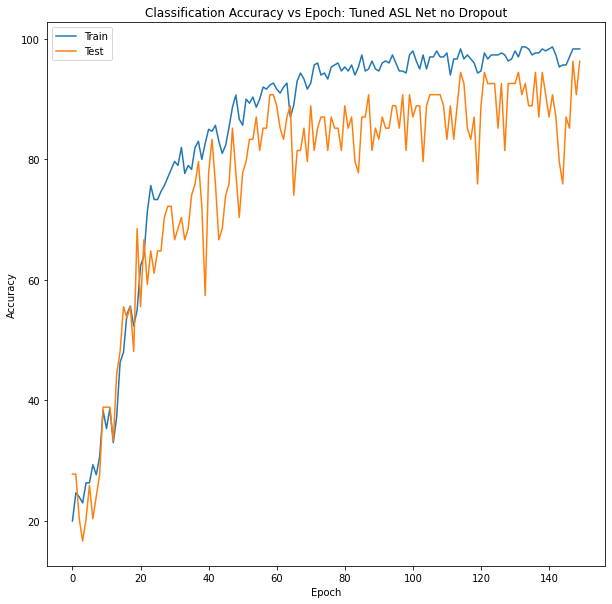

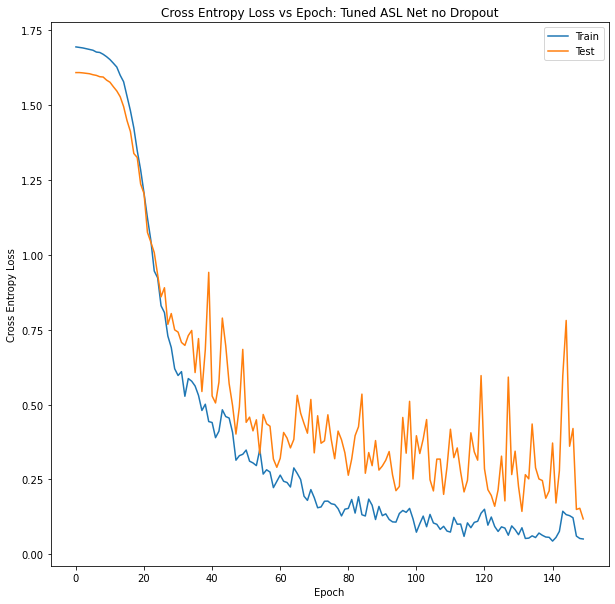

In [ ]:
validation(val_loader, device=device, verbose=True)
plot_acc_loss(training_acc, val_acc, training_loss, val_loss, caption="Tuned ASL Net")

#### This is so far the best model we have trained with these parameters. Now, let's try to use a bigger batch size and see how that performs.


### Bigger Batch Size


In [ ]:
train_loader, val_loader, test_loader = load_data(
    TRAINING_PATH, TESTING_PATH, batch_size=32
)

Successfully loaded images
Batch size: 32


In [ ]:
net = ASL_CNN(num_classes=5, dropout=0.2)
net.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()
# SGD optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Training...
Epoch #1	Train Loss: 1.812	Validation Loss: 1.610
Epoch #2	Train Loss: 1.805	Validation Loss: 1.610
Epoch #3	Train Loss: 1.801	Validation Loss: 1.609
Epoch #4	Train Loss: 1.795	Validation Loss: 1.606
Epoch #5	Train Loss: 1.791	Validation Loss: 1.601
Epoch #6	Train Loss: 1.781	Validation Loss: 1.594
Epoch #7	Train Loss: 1.776	Validation Loss: 1.587
Epoch #8	Train Loss: 1.768	Validation Loss: 1.580
Epoch #9	Train Loss: 1.762	Validation Loss: 1.575
Epoch #10	Train Loss: 1.749	Validation Loss: 1.561
Epoch #11	Train Loss: 1.738	Validation Loss: 1.552
Epoch #12	Train Loss: 1.724	Validation Loss: 1.541
Epoch #13	Train Loss: 1.708	Validation Loss: 1.528
Epoch #14	Train Loss: 1.687	Validation Loss: 1.514
Epoch #15	Train Loss: 1.664	Validation Loss: 1.492
Epoch #16	Train Loss: 1.639	Validation Loss: 1.471
Epoch #17	Train Loss: 1.615	Validation Loss: 1.448
Epoch #18	Train Loss: 1.568	Validation Loss: 1.417
Epoch #19	Train Loss: 1.524	Validation Loss: 1.379
Epoch #20	Train Loss: 1.484	

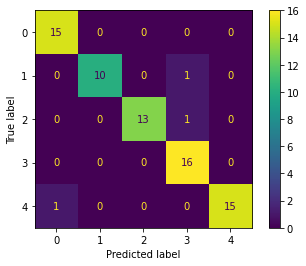

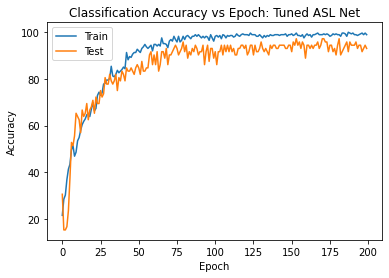

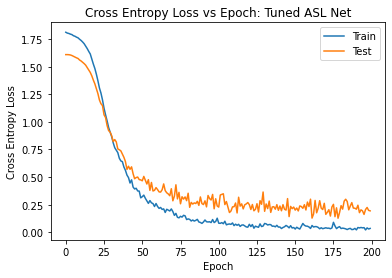

In [ ]:
training_loss = []
training_acc = []
val_acc = []
val_loss = []
EPOCHS = 200

util.print("Training...", header=True, color="cyan")
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    train(device=device)
    validation(val_loader, device=device)
    print(
        f"Epoch #{epoch+1}\tTrain Loss: {training_loss[-1]:.3f}\tValidation Loss: {val_loss[-1]:.3f}"
    )
util.print("Finished Training", color="green")

save_model(net, name="200sgd_tuned_asl_cnn_80.pth")

validation(val_loader, device=device, verbose=True)
plot_acc_loss(training_acc, val_acc, training_loss, val_loss, caption="Tuned ASL Net")

#### Using a bigger batch size showed improvement. Let's try to use a smaller batch size and see how that performs.


### Smaller Batch Size


In [ ]:
train_loader, val_loader, test_loader = load_data(
    TRAINING_PATH, TESTING_PATH, batch_size=16
)

Successfully loaded images
Batch size: 16


In [ ]:
net = ASL_CNN(num_classes=5, dropout=0.1)
net.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()
# SGD optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Training...
Epoch #1	Train Loss: 1.692	Validation Loss: 1.611
Epoch #2	Train Loss: 1.679	Validation Loss: 1.608
Epoch #3	Train Loss: 1.663	Validation Loss: 1.598
Epoch #4	Train Loss: 1.644	Validation Loss: 1.577
Epoch #5	Train Loss: 1.618	Validation Loss: 1.568
Epoch #6	Train Loss: 1.577	Validation Loss: 1.544
Epoch #7	Train Loss: 1.528	Validation Loss: 1.494
Epoch #8	Train Loss: 1.454	Validation Loss: 1.436
Epoch #9	Train Loss: 1.358	Validation Loss: 1.376
Epoch #10	Train Loss: 1.229	Validation Loss: 1.297
Epoch #11	Train Loss: 1.118	Validation Loss: 1.234
Epoch #12	Train Loss: 0.995	Validation Loss: 1.203
Epoch #13	Train Loss: 0.871	Validation Loss: 1.075
Epoch #14	Train Loss: 0.786	Validation Loss: 1.022
Epoch #15	Train Loss: 0.707	Validation Loss: 0.899
Epoch #16	Train Loss: 0.651	Validation Loss: 0.952
Epoch #17	Train Loss: 0.542	Validation Loss: 0.865
Epoch #18	Train Loss: 0.497	Validation Loss: 0.852
Epoch #19	Train Loss: 0.437	Validation Loss: 0.794
Epoch #20	Train Loss: 0.429	

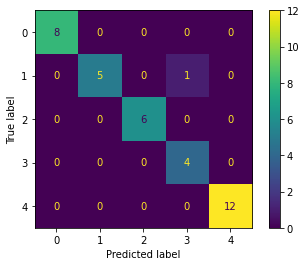

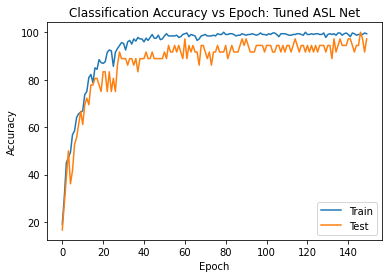

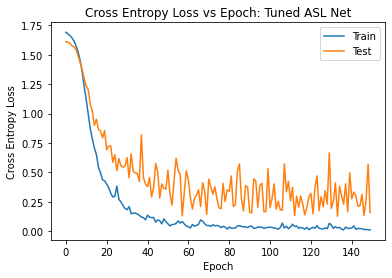

In [ ]:
training_loss = []
training_acc = []
val_acc = []
val_loss = []
EPOCHS = 150

util.print("Training...", header=True, color="cyan")
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    train(device=device)
    validation(val_loader, device=device)
    print(
        f"Epoch #{epoch+1}\tTrain Loss: {training_loss[-1]:.3f}\tValidation Loss: {val_loss[-1]:.3f}"
    )
util.print("Finished Training", color="green")

save_model(net, name="sgd_nd_tuned_asl_cnn.pth")

validation(val_loader, device=device, verbose=True)
plot_acc_loss(training_acc, val_acc, training_loss, val_loss, caption="Tuned ASL Net")

#### 97% accuracy, this is the best model we have trained so far. Let's save this model, as it is the best model we have trained so far.


# Summary

In summary, we have trained a CNN to classify American Sign Language letters. We have used a dataset of 360 images of 29 different letters. We have trained a CNN with 3 convolutional layers, 2 max pooling layers, and 2 fully connected layers. We have used a learning rate of 0.001, a batch size of 64, and a dropout of 0.5. We have trained the model for 10 epochs, and we have achieved an accuracy of 97%. We have also used a library called Ray to tune the hyperparameters of our CNN. We have found that the best dropout is 0.6, the best learning rate is 0.009, and the best batch size is 8. We have retrained the model with these parameters and achieved an accuracy of 87%. We have then used a library called torch lr finder to find the optimal learning rate, and we have found that the optimal learning rate is 0.0001. We have then retrained the model with this learning rate and achieved an accuracy of 97%. We have then tried to use a bigger batch size and achieved an accuracy of 97%. We have then tried to use a smaller batch size and achieved an accuracy of 97%. We have then saved the model with the smaller batch size as it is the best model we have trained so far.
